# Preamble

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import special as sp
from scipy import optimize as opt
import os
import time

import PNRLib as pnr
import DCLib as dc

import warnings
warnings.filterwarnings('ignore')

In [2]:
def getNumberDistribution(binnedClicks, nCycles):
    nMax = len(binnedClicks)-1
    nd = np.zeros(nMax+1)
    for i in range(1, nMax):
        nd[i] = np.sum(binnedClicks[i])/i/nCycles
    nd[0] = 1 - np.sum(nd)
    return nd

# Count Rate Extraction Example

In [3]:
# Set the data location and pick a bin size
fileAddr = os.getcwd() + "\\Sample Data\\APD1_cw_2.txt"
binSize = 1e-9

# Import the data
t0 = time.time()
dataDF = pd.read_csv(fileAddr, delimiter=' ', names=['a','b','c'])
data2 = np.asarray(dataDF['c'])
del dataDF
data2 = data2 - data2[0]
data2 = np.floor(data2[0:10000000]/(binSize/82.3045e-12))
print(time.time()-t0, "seconds to import the data")

# Make the first-and-second and first-and-fourth histogram
t0 = time.time()
h2 = dc.createDiffHistN(2, data2, binSize)
print("2... ", end="")
h4 = dc.createDiffHistN(4, data2, binSize)
print("4... ", end="")
print(time.time()-t0, "seconds to make the histograms")

1.596745491027832 seconds to import the data
2... 4... 1.4362988471984863 seconds to make the histograms


In [10]:
# This is the count rate extraction step: fit the first-and-fourth histogram

# Appropriate fit function for a first-and-fourth histogram
def fitFunc(t, a, r, t0):
    return 0.5*a*(r*(t-t0))**2*np.exp(-r*(t-t0))

# This index is a proxy for the maximum of where to start the fit
iFit = round(np.argmax(h4[1][75:])/2)+75
# Do the fit to the histogram
soln = opt.curve_fit(fitFunc, h4[0][iFit:], h4[1][iFit:], p0=np.array([1e3, 1e6, 75e-9]), maxfev=10000)
cr = soln[0][1]
# Print the count rate
print("Count rate: {:.6f} Mc/s".format(cr/1e6))

Count rate: 9.532811 Mc/s


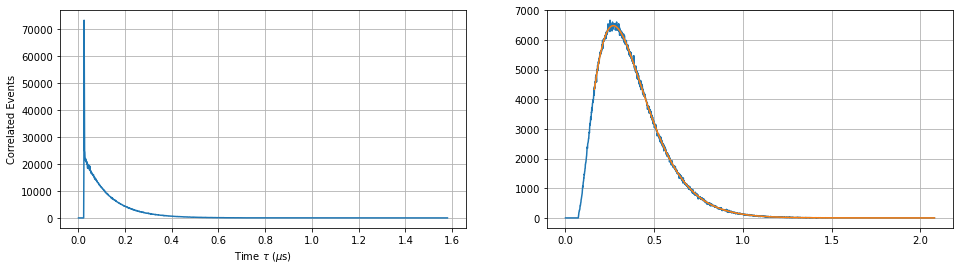

In [13]:
# Visualize the click number distribution and the pulse shape as seen by the APDs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(h2[0]*1e6, h2[1])
ax1.xaxis.grid(True); ax1.yaxis.grid(True)
ax1.set_xlabel('Time $\\tau$ ($\\mu$s)'); ax1.set_ylabel('Correlated Events')

ax2.plot(h4[0]*1e6, h4[1])
ax2.plot(h4[0][iFit:]*1e6, fitFunc(h4[0][iFit:], soln[0][0], soln[0][1], soln[0][2]))
ax2.xaxis.grid(True); ax2.yaxis.grid(True)
ax1.set_xlabel('Time $\\tau$ ($\\mu$s)'); ax1.set_ylabel('Correlated Events')

plt.show()

# Reconstruction Template

For us, the sample data is a set of histograms of clicks vs binned time the clicks occurred. We have sorted the clicks in the following way: binnedClicks[0] contains all clicks, and then binnedClicks[n] contains clicks from only the experimental runs where exactly n clicks occurred, with n running from 1 to some maximum. Using the length of each histogram we are able to obtain the data collection window length. We also use the knowledge of the number of experimental runs for each of our tomography measurements and the bin size we previously chose.

In [3]:
# Import SPAD data
binnedClicks = np.loadtxt(os.getcwd() + "\\Sample Data\\" + "bc_1us-SPAD1.txt", delimiter=",")

# Constants and Experimental Parameters
tagger_resolution = 164.609e-12
nCycles = 750*40000
dt = 1e-9
bin_width = round(dt/tagger_resolution)*tagger_resolution
bins_per_window = len(binnedClicks[0])
window_width = bins_per_window*bin_width

# Get the number distribution
numberDist = getNumberDistribution(binnedClicks, nCycles)

print("Window width: {:.3} us".format(window_width*1e6))
print("Number distribution:")
print(numberDist)

Window width: 1.5 us
Number distribution:
[2.86560800e-01 3.62630367e-01 2.26027567e-01 9.10311667e-02
 2.65202667e-02 5.97810000e-03 1.06780000e-03 1.61066667e-04
 2.05666667e-05 2.13333333e-06 1.33333333e-07 3.33333333e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


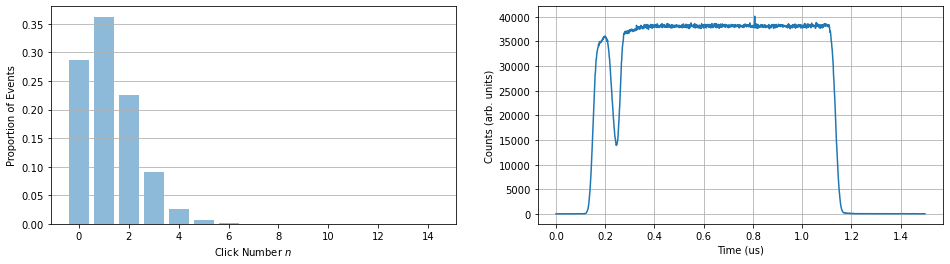

In [4]:
# Visualize the click number distribution and the pulse shape as seen by the APDs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.bar(np.array(range(len(numberDist))), numberDist, align='center', alpha=0.5, ecolor='black', capsize=4)
ax1.set_xlabel('Click Number $n$'); ax1.set_ylabel('Proportion of Events')
ax1.yaxis.grid(True)

ax2.plot(np.arange(0, bins_per_window)*bin_width*1e6 + bin_width/2, binnedClicks[0])
ax2.xaxis.grid(True); ax2.yaxis.grid(True)
ax2.set_xlabel('Time (us)'); ax2.set_ylabel('Counts (arb. units)')

plt.show()

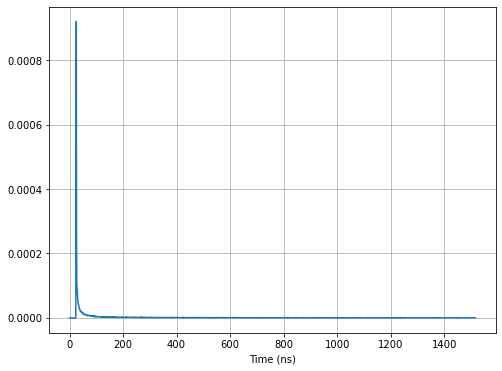

Afterpulsing probability pA = 0.0039055512


In [5]:
# Now do the afterpulsing convolution

# Get the afterpulsing profile data
AP_profile_file = os.getcwd() + "\\Sample Data\\AP_Profile_SPAD1.csv"
dataAP_raw = np.transpose(np.asarray(pd.read_csv(AP_profile_file, delimiter=',', header=None))[:len(binnedClicks[0])])

# Visualize the afterpulsing profile
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dataAP_raw[0]*1e9, dataAP_raw[1])
ax.xaxis.grid(True); ax.yaxis.grid(True); ax.set_xlabel('Time (ns)')
plt.show()

# Do the convolution
# We measure the probability of afterpulsing within 2t_rec
# pA0 is the probability, and pA0endInd is the index of 2t_rec
pA0 = 0.002665
pA0endInd = round(4.7078174e-08/bin_width)
# The signal pulse to convolve with
normedSignalData = binnedClicks[0]/np.sum(binnedClicks[0])
# More setup, and do the convolution
n0 = len(normedSignalData)
cutPAdata = dataAP_raw[1][0:n0]
integratedPAdata = np.zeros(n0)
normFactor = pA0/np.sum(dataAP_raw[1][0:pA0endInd+1])
for i in range(n0):
    integratedPAdata[i] = np.sum(cutPAdata[0:n0-i]*normFactor)
convDataFinal = normedSignalData * integratedPAdata
pAconv = np.sum(convDataFinal)

print("Afterpulsing probability pA = {:.10f}".format(pAconv))

In [6]:
# Get the detector matrix
nMax = 10

# Click number distribution
expDist = numberDist[0:nMax+1]

# Detector parameters for SPAD1 and relevant photon profile
eta = 0.633114
pB = 263.3*window_width
pA = pAconv
tD = np.array([1.471737e-8, 2.354150e-8])
p1data = binnedClicks[1]/nCycles

# Get the detector matrix
t0 = time.time()
matD = pnr.getExpMatrix(nMax, eta, pB, pA, tD, bin_width, p1data, window_width, RTorder = 2, RTbrko = 0)
print((time.time()-t0)/60, "minutes to complete")

# Run the EME algorithm and get the reconstructed distribution
recon_eme = pnr.getInputDist_EME(expDist, matD, l=0.5e-2, iterations=1e10, epsilon=1e-12)

Starting the dead time matrix construction. Computing normalization factors... Generating strings... Completed in 0.30954456329345703 seconds. Beginning integrals. We have 651 to do... Completed in 20.181817770004272 seconds.
0.34289079904556274 minutes to complete


In [7]:
nMax = 10

expDist = numberDist[0:nMax+1]
p1data = binnedClicks[1]/nCycles

# In this example notebook, the values for the given parameters are measured
# but the uncertainties are larger than what we measured, just for the sake of example
eta0 = np.array([0.633114, 0.633114*0.03])
pB = np.array([263.3, 5])*window_width
pA = np.array([0.02262260929414759, 0.02262260929414759*0.05])
tD = np.array([1.47173739e-08, 1e-10])
tRec = np.array([2.35415007e-08, 1e-10])

reconDists = pnr.getReconDistErrorsP(25, expDist, nMax, eta0, pB, pA, tD, tRec, bin_width, p1data, window_width, RTorder = 2, RTbrko = 0, CPUs = 0)
u_dist = np.std(reconDists, axis=0)

Done.


The fitted average photon number is 1.986.


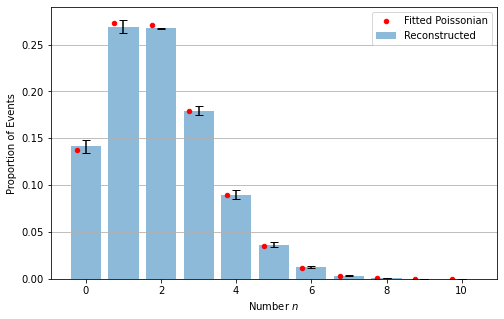

In [19]:
# Visualize the reconstructed number distribution, with the above uncertainties,
# and fit it to a Poissonian distribution
cohSoln = opt.curve_fit(pnr.coherentStateFitFunc, np.arange(0,len(recon_eme)), recon_eme, p0=np.array([2.0]), maxfev = 10000)
ndCohFitted, _ = pnr.getCohDistErrors(cohSoln[0][0], 0, len(recon_eme))

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(np.array(range(nMax+1)), recon_eme, yerr=u_dist, align='center', alpha=0.5, capsize=4)
ax.scatter(np.array(range(nMax+1))-0.25, ndCohFitted, color='red', s=20)
ax.set_xlabel('Number $n$'); ax.set_ylabel('Proportion of Events')
ax.legend(('Fitted Poissonian', 'Reconstructed'))
ax.yaxis.grid(True)

print("The fitted average photon number is {:.3f}.".format(cohSoln[0][0]))
plt.show()